In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer
from catboost import CatBoostClassifier

import optuna
import shap
import warnings
warnings.filterwarnings('ignore')

C:\Users\Zafer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('turkishCF.csv', sep=';', on_bad_lines='skip')

In [4]:
df.head()

,id,platform_adi,kitle_fonlamasi_turu,kategori,fon_sekli,proje_adi,proje_sahibi,proje_sahibi_cinsiyet,kac_proje_destekledi,kac_projeye_abone,kac_projenin_sahibi,kac_proje_takiminda,konum,bolge,yil,proje_baslama_tarihi,proje_bitis_tarihi,gun_sayisi,tanitim_videosu,video_uzunlugu,gorsel_sayisi,sss,guncellemeler,yorumlar,destekci_sayisi,odul_sayisi,ekip_kisi_sayisi,web_sitesi,sosyal_medya,sm_sayisi,sm_takipci,etiket_sayisi,icerik_kelime_sayisi,proje_aciklamasi,hedef_miktari,toplanan_tutar,destek_orani,basari_durumu
0,1,fongogo,ödül,diğer,ya hep ya hiç,Gerçek Gizlidir Filmleri,Lob Ekibi,belirsiz,1,0,1,0,istanbul,marmara,2014,15.09.2014,16.11.2014,62,var,104,1,0,4,0,150,11,4,yok,var,3,274,0,301,Türkiye’de ilk kez her aşaması ‘online’ olarak...,40000,54410,136%,başarılı
1,2,fongogo,ödül,diğer,ya hep ya hiç,Fongogo - Hayat Bulsun!,Fongogo Team,belirsiz,3,0,2,0,istanbul,marmara,2015,4.05.2015,3.07.2015,60,yok,0,12,0,0,0,51,11,7,yok,var,3,5634,0,167,"Fongogo ekibi olarak büyümek, daha geniş kitle...",50000,50110,100%,başarılı
2,3,fongogo,ödül,diğer,ya hep ya hiç,"PAYLAŞIMIN, SEVGİNİN VE ÇOCUKLARIN İYİLİK EVİ ...",SİNEM CAN,kadın,0,0,2,1,belirsiz,belirsiz,2017,NaN,13.06.2017,60,var,60,8,1,1,1,25,6,2,var,var,2,510,4,413,Çocuklara her şeyin ücretsiz olduğu iyilik evi...,47000,47850,101%,başarılı
3,4,fongogo,ödül,diğer,ya hep ya hiç,Türk Kadının 100.yıl Seyri,Deniz Tutkusu Seyirde,kadın,0,0,1,0,muğla,ege,2019,19.04.2019,18.06.2019,60,var,67,6,0,0,0,45,7,1,var,var,2,3338,5,287,‘Sözde değil Özde İzindeyiz ‘ sloganıyla Atatü...,35000,35450,101%,başarılı
4,5,fongogo,ödül,diğer,ya hep ya hiç,Doğadaki Çocuk,Seren Kutadgu,kadın,2,0,1,0,istanbul,marmara,2019,2.09.2019,1.11.2019,60,var,149,5,0,0,0,105,8,6,yok,var,1,144,3,571,İstanbul'daki çocuk yuvalarında yaşayan dezava...,30000,31250,104%,başarılı


In [5]:
rename_dict = {
    'platform_adi': 'platform_name',
    'kitle_fonlamasi_turu': 'crowdfunding_type',
    'kategori': 'category',
    'fon_sekli': 'fund_type',
    'proje_adi': 'project_name',
    'proje_sahibi': 'project_owner',
    'proje_sahibi_cinsiyet': 'project_owner_gender',
    'kac_proje_destekledi': 'number_of_supported_projects',
    'kac_projeye_abone': 'number_of_subscribed_projects',
    'kac_projenin_sahibi': 'number_of_projects_owners',
    'kac_proje_takiminda': 'number_of_team_members_in_projects',
    'konum': 'location',
    'bolge': 'region',
    'yil': 'year',
    'proje_baslama_tarihi': 'project_start_date',
    'proje_bitis_tarihi': 'project_end_date',
    'gun_sayisi': 'number_of_days',
    'tanitim_videosu': 'promotion_video',
    'video_uzunlugu': 'video_length',
    'gorsel_sayisi': 'number_of_images',
    'sss': 'faq',
    'guncellemeler': 'updates',
    'yorumlar': 'comments',
    'destekci_sayisi': 'number_of_supporters',
    'odul_sayisi': 'number_of_awards',
    'ekip_kisi_sayisi': 'number_of_team_members',
    'web_sitesi': 'website',
    'sosyal_medya': 'social_media',
    'sm_sayisi': 'number_of_social_media_accounts',
    'sm_takipci': 'social_media_followers',
    'etiket_sayisi': 'number_of_tags',
    'icerik_kelime_sayisi': 'number_of_words_in_content',
    'proje_aciklamasi': 'project_description',
    'hedef_miktari': 'target_amount',
    'toplanan_tutar': 'amount_collected',
    'destek_orani': 'support_rate',
    'basari_durumu': 'success_status'
}

df.rename(columns=rename_dict, inplace=True)

In [6]:
var_yok_rename = {'var': 'yes', 'yok': 'no'}
success_status_rename = {'başarılı': 'successful', 'başarısız': 'unsuccessful'}
category_rename = {
    'film-video-fotoğraf': 'film-video-photography',
    'teknoloji': 'technology',
    'kültür-sanat': 'culture-arts',
    'eğitim': 'education',
    'diğer': 'other',
    'çevre': 'environment',
    'müzik': 'music',
    'sağlık-güzellik': 'health-beauty',
    'tasarım': 'design',
    'yayıncılık': 'publishing',
    'gıda-yeme-içme': 'food-drink',
    'spor': 'sports',
    'hayvanlar': 'animals',
    'moda': 'fashion',
    'sosyal sorumluluk': 'social-responsibility',
    'dans-performans': 'dance-performance',
    'turizm': 'tourism'
}
kitle_fonlamasi_turu_rename = {
    'ödül': 'reward',
    'bağış': 'donation'
}
fon_sekli_rename = {
    'ya hep ya hiç': 'all or nothing',
    'hepsi kalsın': 'flexible'
}
proje_sahibi_rename = {
    'erkek': 'male',
    'kadın': 'female',
    'belirsiz': 'unknown'
}
bolge_rename = {
    'marmara': 'Marmara',
    'ege': 'Aegean',
    'akdeniz': 'Mediterranean',
    'iç anadolu': 'Central Anatolia',
    'doğu anadolu': 'Eastern Anatolia',
    'güneydoğu anadolu': 'Southeastern Anatolia',
    'karadeniz': 'Black Sea',
    'belirsiz': 'unknown',
    'genel': 'unknown'
}


df['promotion_video'] = df['promotion_video'].map(var_yok_rename)
df['website'] = df['website'].map(var_yok_rename)
df['social_media'] = df['social_media'].map(var_yok_rename)
df['success_status'] = df['success_status'].map(success_status_rename)
df['category'] = df['category'].map(category_rename)
df['crowdfunding_type'] = df['crowdfunding_type'].map(kitle_fonlamasi_turu_rename)
df['fund_type'] = df['fund_type'].map(fon_sekli_rename)
df['project_owner_gender'] = df['project_owner_gender'].map(proje_sahibi_rename)
df['region'] = df['region'].map(bolge_rename)



In [7]:
df.head()

,id,platform_name,crowdfunding_type,category,fund_type,project_name,project_owner,project_owner_gender,number_of_supported_projects,number_of_subscribed_projects,number_of_projects_owners,number_of_team_members_in_projects,location,region,year,project_start_date,project_end_date,number_of_days,promotion_video,video_length,number_of_images,faq,updates,comments,number_of_supporters,number_of_awards,number_of_team_members,website,social_media,number_of_social_media_accounts,social_media_followers,number_of_tags,number_of_words_in_content,project_description,target_amount,amount_collected,support_rate,success_status
0,1,fongogo,reward,other,all or nothing,Gerçek Gizlidir Filmleri,Lob Ekibi,unknown,1,0,1,0,istanbul,Marmara,2014,15.09.2014,16.11.2014,62,yes,104,1,0,4,0,150,11,4,no,yes,3,274,0,301,Türkiye’de ilk kez her aşaması ‘online’ olarak...,40000,54410,136%,successful
1,2,fongogo,reward,other,all or nothing,Fongogo - Hayat Bulsun!,Fongogo Team,unknown,3,0,2,0,istanbul,Marmara,2015,4.05.2015,3.07.2015,60,no,0,12,0,0,0,51,11,7,no,yes,3,5634,0,167,"Fongogo ekibi olarak büyümek, daha geniş kitle...",50000,50110,100%,successful
2,3,fongogo,reward,other,all or nothing,"PAYLAŞIMIN, SEVGİNİN VE ÇOCUKLARIN İYİLİK EVİ ...",SİNEM CAN,female,0,0,2,1,belirsiz,unknown,2017,NaN,13.06.2017,60,yes,60,8,1,1,1,25,6,2,yes,yes,2,510,4,413,Çocuklara her şeyin ücretsiz olduğu iyilik evi...,47000,47850,101%,successful
3,4,fongogo,reward,other,all or nothing,Türk Kadının 100.yıl Seyri,Deniz Tutkusu Seyirde,female,0,0,1,0,muğla,Aegean,2019,19.04.2019,18.06.2019,60,yes,67,6,0,0,0,45,7,1,yes,yes,2,3338,5,287,‘Sözde değil Özde İzindeyiz ‘ sloganıyla Atatü...,35000,35450,101%,successful
4,5,fongogo,reward,other,all or nothing,Doğadaki Çocuk,Seren Kutadgu,female,2,0,1,0,istanbul,Marmara,2019,2.09.2019,1.11.2019,60,yes,149,5,0,0,0,105,8,6,no,yes,1,144,3,571,İstanbul'daki çocuk yuvalarında yaşayan dezava...,30000,31250,104%,successful


In [8]:
df.drop(columns=['id','project_owner'], inplace=True)

In [9]:
df['project_end_date'] = df['project_end_date'].replace({'18.Oca.16': '18.01.2016'})

In [10]:
df['project_start_date'] = pd.to_datetime(df['project_start_date'])
df['project_end_date'] = pd.to_datetime(df['project_end_date'], format='mixed', dayfirst=True)
df['support_rate'] = df['support_rate'].str.replace('%', '')
df['support_rate'] = df['support_rate'].astype(float) / 100 

In [11]:
df.describe()

,number_of_supported_projects,number_of_subscribed_projects,number_of_projects_owners,number_of_team_members_in_projects,year,project_start_date,project_end_date,number_of_days,video_length,number_of_images,faq,updates,comments,number_of_supporters,number_of_awards,number_of_team_members,number_of_social_media_accounts,social_media_followers,number_of_tags,number_of_words_in_content,target_amount,amount_collected,support_rate
count,1628.000000,1628.000000,1628.000000,1628.000000,1628.000000,1017,1075,1628.000000,1628.000000,1628.000000,1628.000000,1628.000000,1628.000000,1628.000000,1628.000000,1628.000000,1628.000000,1628.000000,1628.000000,1628.000000,1.628000e+03,1.628000e+03,1628.000000
mean,0.429361,0.000614,1.165848,0.052826,2018.042383,2018-10-21 03:11:09.026548736,2018-11-21 16:41:58.325581056,52.004914,67.668305,5.036855,0.203317,0.512899,1.295455,24.084767,5.979730,1.810197,1.033170,2541.066953,1.374693,354.221744,3.113431e+04,1.142884e+04,0.392230
min,0.000000,0.000000,1.000000,0.000000,2011.000000,2013-12-02 00:00:00,2014-01-07 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000
25%,0.000000,0.000000,1.000000,0.000000,2017.000000,2018-03-19 00:00:00,2017-12-31 00:00:00,45.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000,0.000000,134.750000,6.150000e+03,0.000000e+00,0.000000
50%,0.000000,0.000000,1.000000,0.000000,2019.000000,2019-05-19 00:00:00,2019-06-17 00:00:00,60.000000,46.000000,3.000000,0.000000,0.000000,0.000000,3.000000,6.000000,1.000000,1.000000,4.000000,0.000000,277.500000,1.500000e+04,2.500000e+02,0.020000
75%,0.000000,0.000000,1.000000,0.000000,2020.000000,2020-03-18 00:00:00,2020-05-01 00:00:00,60.000000,98.250000,7.000000,0.000000,0.000000,0.000000,18.000000,8.000000,2.000000,2.000000,498.250000,4.000000,464.250000,3.500000e+04,4.207500e+03,0.435000
max,31.000000,1.000000,7.000000,4.000000,2021.000000,2021-01-22 00:00:00,2021-03-09 00:00:00,118.000000,1651.000000,221.000000,30.000000,71.000000,400.000000,1994.000000,29.000000,28.000000,4.000000,534300.000000,12.000000,3473.000000,1.453000e+06,2.666800e+06,113.000000
std,2.225029,0.024784,0.710455,0.244744,2.054583,NaN,NaN,15.294526,108.145452,7.842166,1.439136,2.409611,12.214556,82.257217,2.231298,1.851983,1.225174,19468.390705,2.142645,300.196873,6.568972e+04,8.474755e+04,2.904456


In [12]:
for i in range(0,36,20):
    display(df[df.columns[i:i+20]].describe(include = ['object']))

,platform_name,crowdfunding_type,category,fund_type,project_name,project_owner_gender,location,region,promotion_video
count,1628,1628,1628,1628,1628,1628,1628,1562,1628
unique,6,2,17,2,1607,3,66,6,2
top,fongogo,reward,film-video-photography,all or nothing,Satılmalı.com,male,istanbul,Marmara,yes
freq,1075,1618,389,1509,3,1148,547,638,947


,website,social_media,project_description,success_status
count,1628,1628,1628,1628
unique,2,2,1608,2
top,no,yes,Tüm güzellik hizmeti veren işletmeler gibi zor...,unsuccessful
freq,1212,833,6,1252


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1628 entries, 0 to 1627
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   platform_name                       1628 non-null   object        
 1   crowdfunding_type                   1628 non-null   object        
 2   category                            1628 non-null   object        
 3   fund_type                           1628 non-null   object        
 4   project_name                        1628 non-null   object        
 5   project_owner_gender                1628 non-null   object        
 6   number_of_supported_projects        1628 non-null   int64         
 7   number_of_subscribed_projects       1628 non-null   int64         
 8   number_of_projects_owners           1628 non-null   int64         
 9   number_of_team_members_in_projects  1628 non-null   int64         
 10  location                

In [14]:
df.isna().sum().sort_values(ascending=False)

project_start_date                    611
project_end_date                      553
region                                 66
platform_name                           0
social_media                            0
number_of_supporters                    0
number_of_awards                        0
number_of_team_members                  0
website                                 0
number_of_social_media_accounts         0
updates                                 0
social_media_followers                  0
number_of_tags                          0
number_of_words_in_content              0
project_description                     0
target_amount                           0
amount_collected                        0
support_rate                            0
comments                                0
number_of_images                        0
faq                                     0
crowdfunding_type                       0
video_length                            0
promotion_video                   

In [15]:
df['number_of_subscribed_projects'].value_counts()

number_of_subscribed_projects
0    1627
1       1
Name: count, dtype: int64

In [16]:
df.drop('number_of_subscribed_projects', axis=1, inplace=True)

![Number of Supporters per City](./map.png)

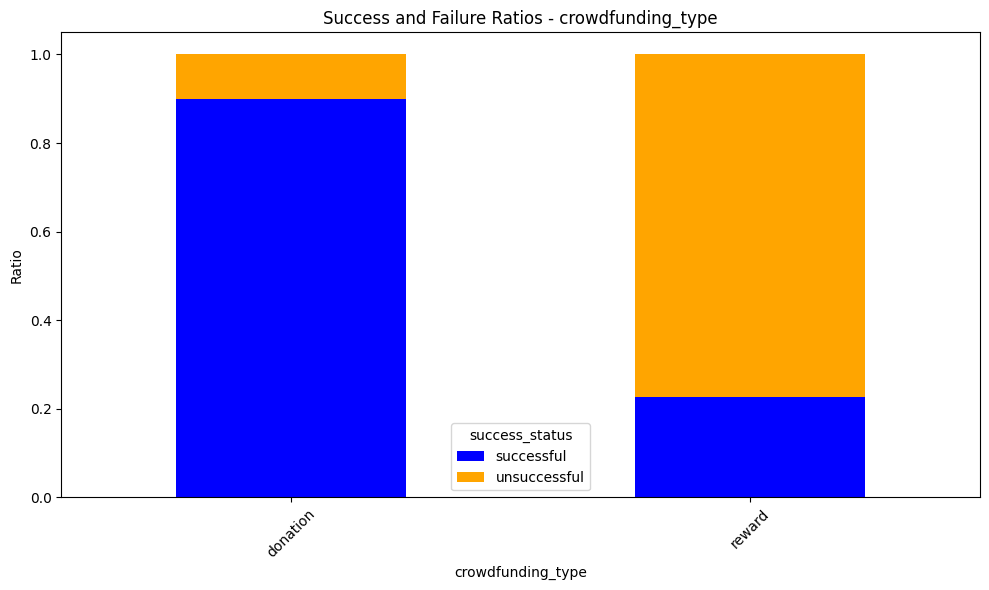

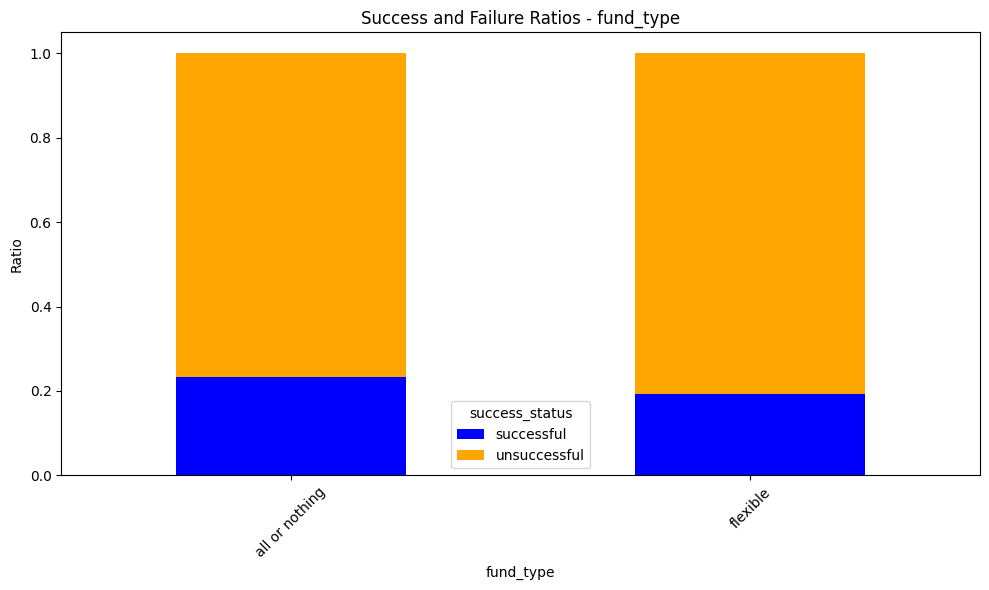

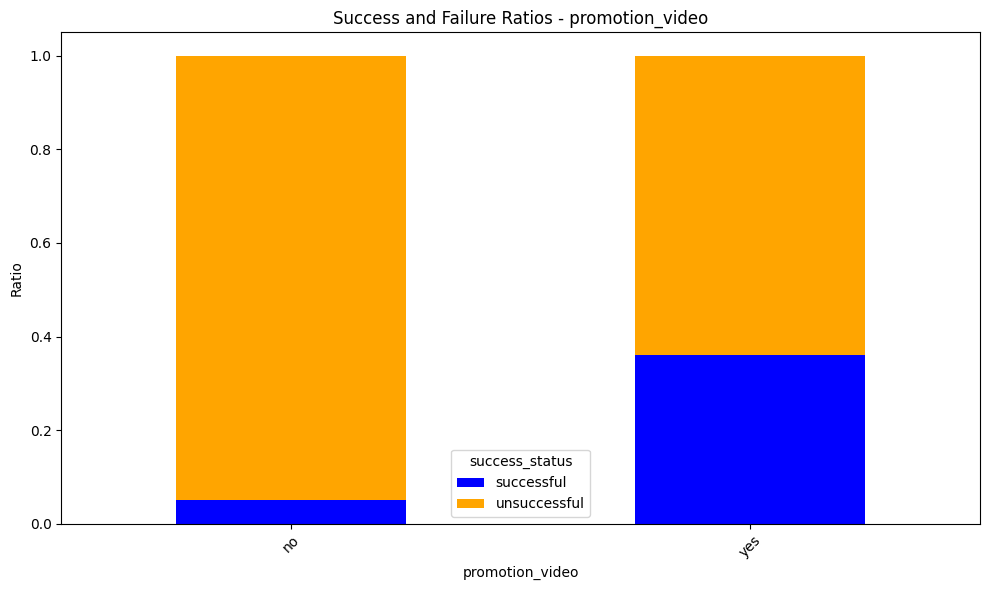

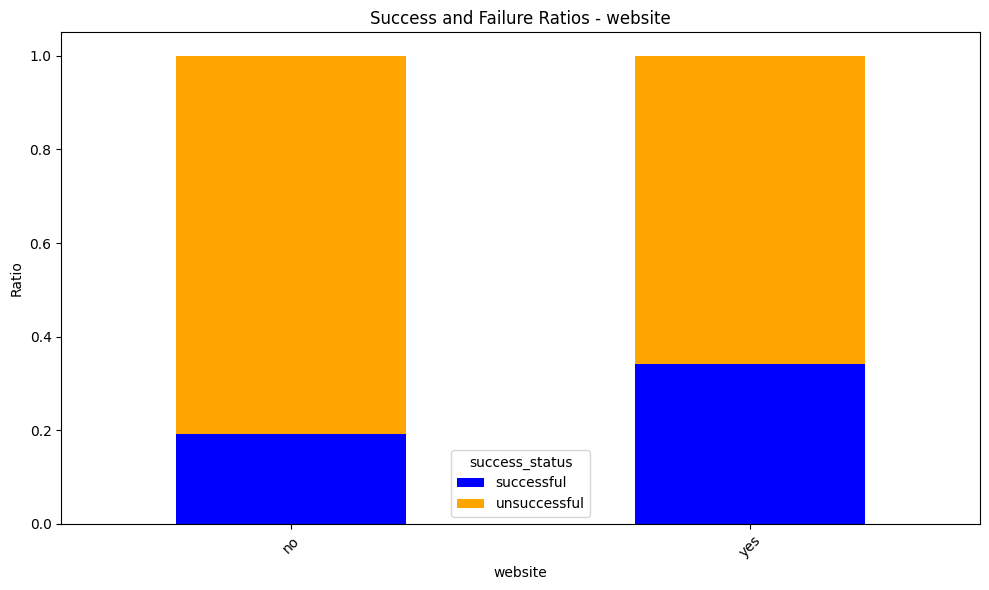

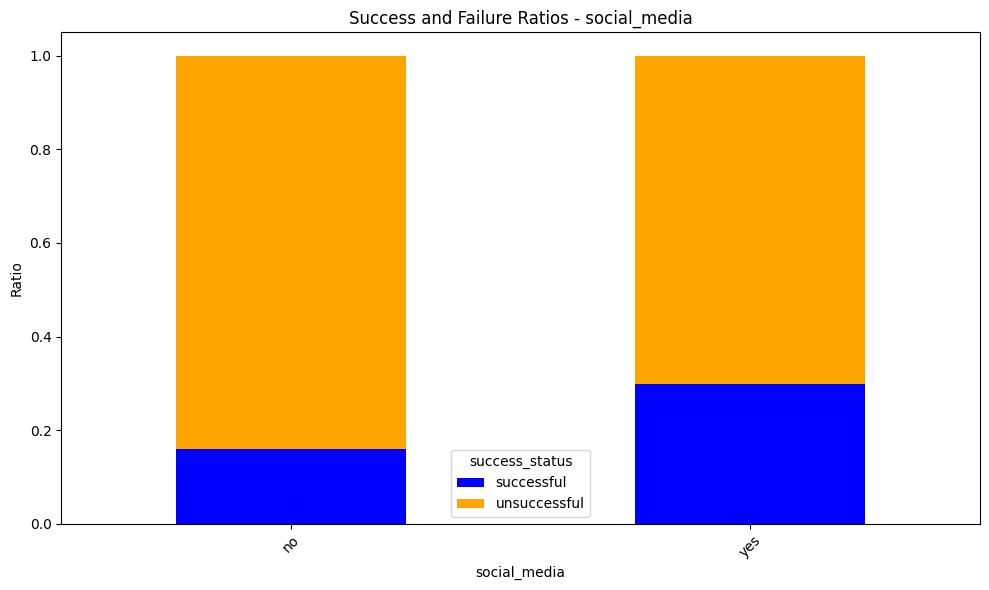

In [17]:
categorical_columns = [col for col in df.columns if df[col].nunique() == 2 and col != 'success_status']

for col in categorical_columns:
    plt.figure(figsize=(10, 6))
    
    success_fail_counts = df.groupby([col, 'success_status']).size().unstack(fill_value=0)

    success_fail_ratios = success_fail_counts.div(success_fail_counts.sum(axis=1), axis=0)

    success_fail_ratios.plot(kind='bar', stacked=True, color=['blue', 'orange'], ax=plt.gca())
    
    plt.title(f"Success and Failure Ratios - {col}")
    plt.ylabel("Ratio")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

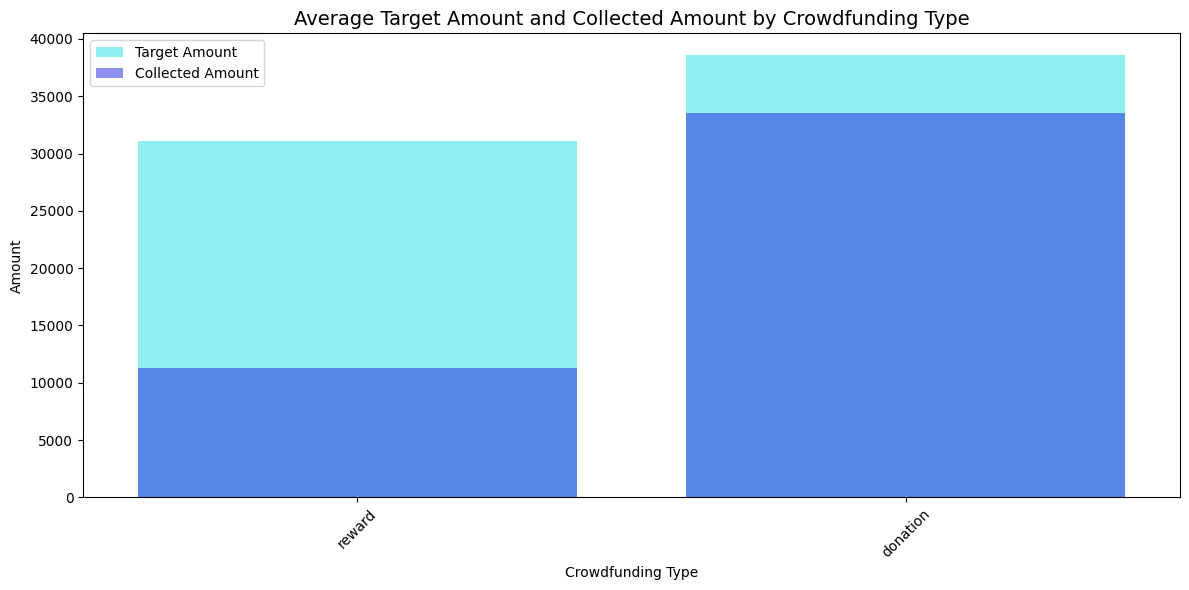

In [18]:
plt.figure(figsize=(12, 6))
sns.barplot(x='crowdfunding_type', y='target_amount', data=df, estimator='mean', ci=None,color='cyan', alpha=0.5, label='Target Amount')
sns.barplot(x='crowdfunding_type', y='amount_collected', data=df, estimator='mean', ci=None, color='blue', alpha=0.5, label='Collected Amount')
plt.title('Average Target Amount and Collected Amount by Crowdfunding Type', fontsize=14)
plt.xlabel('Crowdfunding Type')
plt.ylabel('Amount')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

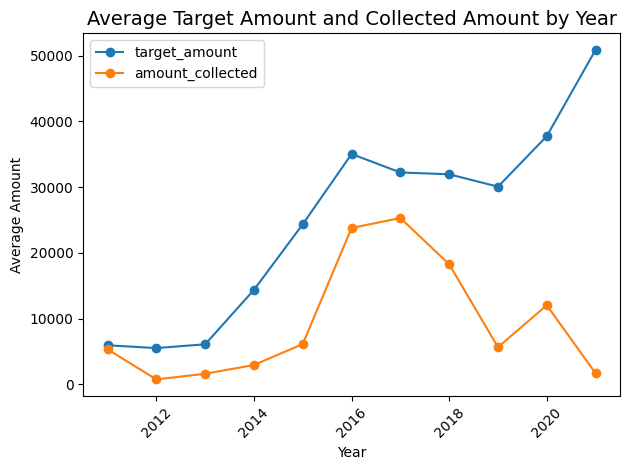

In [19]:
year_average = df.groupby('year')[['target_amount', 'amount_collected']].mean()

plt.figure(figsize=(10, 6))
year_average.plot(kind='line', marker='o')
plt.title('Average Target Amount and Collected Amount by Year', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Average Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

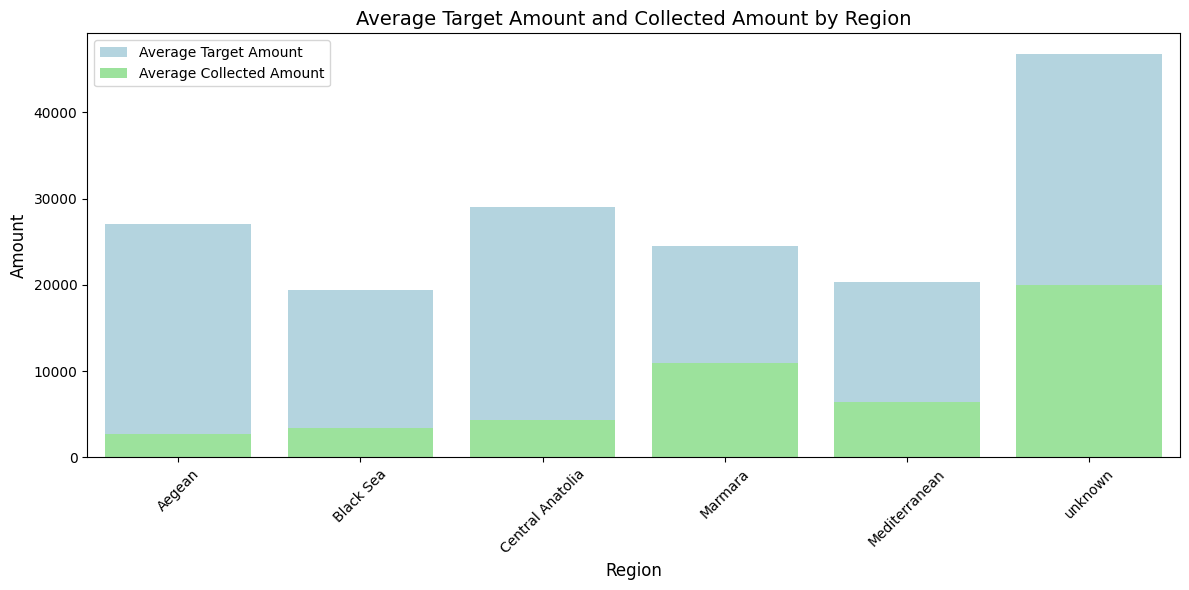

In [20]:
amount_by_region = df.groupby('region')[['target_amount', 'amount_collected']].mean().reset_index()


plt.figure(figsize=(12, 6))


sns.barplot(x='region', y='target_amount', data=amount_by_region, color='lightblue', label='Average Target Amount', ci=None)
sns.barplot(x='region', y='amount_collected', data=amount_by_region, color='lightgreen', label='Average Collected Amount', ci=None)

plt.title('Average Target Amount and Collected Amount by Region', fontsize=14)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Amount', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
df.isna().sum().sort_values(ascending=False)

project_start_date                    611
project_end_date                      553
region                                 66
platform_name                           0
number_of_supporters                    0
number_of_awards                        0
number_of_team_members                  0
website                                 0
social_media                            0
number_of_social_media_accounts         0
updates                                 0
social_media_followers                  0
number_of_tags                          0
number_of_words_in_content              0
project_description                     0
target_amount                           0
amount_collected                        0
support_rate                            0
comments                                0
number_of_images                        0
faq                                     0
crowdfunding_type                       0
video_length                            0
promotion_video                   

In [22]:
df['region'].fillna(df['region'].mode()[0], inplace=True)

In [23]:
df.fillna(0, inplace=True)

In [24]:
encoder = LabelEncoder()

columns_to_encode = ['platform_name', 'crowdfunding_type','project_owner_gender' ,'category', 'fund_type', 'location', 'region']

for col in columns_to_encode:
    df[col] = df[col].replace('unknown', 0).astype(str)
    df[col] = encoder.fit_transform(df[col])


In [25]:
yes_no_mapping = {'yes': 1, 'no': 0}
success_status_mapping = {'successful': 1, 'unsuccessful': 0}

df['promotion_video'] = df['promotion_video'].map(yes_no_mapping)
df['website'] = df['website'].map(yes_no_mapping)
df['social_media'] = df['social_media'].map(yes_no_mapping)
df['success_status'] = df['success_status'].map(success_status_mapping)

In [26]:
df.head()

,platform_name,crowdfunding_type,category,fund_type,project_name,project_owner_gender,number_of_supported_projects,number_of_projects_owners,number_of_team_members_in_projects,location,region,year,project_start_date,project_end_date,number_of_days,promotion_video,video_length,number_of_images,faq,updates,comments,number_of_supporters,number_of_awards,number_of_team_members,website,social_media,number_of_social_media_accounts,social_media_followers,number_of_tags,number_of_words_in_content,project_description,target_amount,amount_collected,support_rate,success_status
0,4,1,11,0,Gerçek Gizlidir Filmleri,0,1,1,0,26,4,2014,2014-09-15 00:00:00,2014-11-16 00:00:00,62,1,104,1,0,4,0,150,11,4,0,1,3,274,0,301,Türkiye’de ilk kez her aşaması ‘online’ olarak...,40000,54410,1.36,1
1,4,1,11,0,Fongogo - Hayat Bulsun!,0,3,2,0,26,4,2015,2015-05-04 00:00:00,2015-07-03 00:00:00,60,0,0,12,0,0,0,51,11,7,0,1,3,5634,0,167,"Fongogo ekibi olarak büyümek, daha geniş kitle...",50000,50110,1.00,1
2,4,1,11,0,"PAYLAŞIMIN, SEVGİNİN VE ÇOCUKLARIN İYİLİK EVİ ...",1,0,2,1,13,0,2017,0,2017-06-13 00:00:00,60,1,60,8,1,1,1,25,6,2,1,1,2,510,4,413,Çocuklara her şeyin ücretsiz olduğu iyilik evi...,47000,47850,1.01,1
3,4,1,11,0,Türk Kadının 100.yıl Seyri,1,0,1,0,42,1,2019,2019-04-19 00:00:00,2019-06-18 00:00:00,60,1,67,6,0,0,0,45,7,1,1,1,2,3338,5,287,‘Sözde değil Özde İzindeyiz ‘ sloganıyla Atatü...,35000,35450,1.01,1
4,4,1,11,0,Doğadaki Çocuk,1,2,1,0,26,4,2019,2019-09-02 00:00:00,2019-11-01 00:00:00,60,1,149,5,0,0,0,105,8,6,0,1,1,144,3,571,İstanbul'daki çocuk yuvalarında yaşayan dezava...,30000,31250,1.04,1


In [27]:
sentence_transformer_model = SentenceTransformer("dbmdz/bert-base-turkish-128k-uncased")

df_embeddings_description = sentence_transformer_model.encode(df['project_description'].fillna(""))
df_embeddings_name = sentence_transformer_model.encode(df['project_name'].fillna(""))


df[[f"nn_emb_desc_{i}" for i in range(df_embeddings_description.shape[1])]] = df_embeddings_description
df[[f"nn_emb_name_{i}" for i in range(df_embeddings_name.shape[1])]] = df_embeddings_name

No sentence-transformers model found with name dbmdz/bert-base-turkish-128k-uncased. Creating a new one with mean pooling.


In [28]:
df.head()

platform_name  crowdfunding_type  category  fund_type  \
0              4                  1        11          0   
1              4                  1        11          0   
2              4                  1        11          0   
3              4                  1        11          0   
4              4                  1        11          0   

                                        project_name  project_owner_gender  \
0                           Gerçek Gizlidir Filmleri                     0   
1                            Fongogo - Hayat Bulsun!                     0   
2  PAYLAŞIMIN, SEVGİNİN VE ÇOCUKLARIN İYİLİK EVİ ...                     1   
3                         Türk Kadının 100.yıl Seyri                     1   
4                                     Doğadaki Çocuk                     1   

   number_of_supported_projects  number_of_projects_owners  \
0                             1                          1   
1                             3                          2   
2                             0                          2   
3                             0                          1   
4                             2                          1   

   number_of_team_members_in_projects  location  region  year  \
0                                   0        26       4  2014   
1                                   0        26       4  2015   
2                                   1        13       0  2017   
3                                   0        42       1  2019   
4                                   0        26       4  2019   

    project_start_date     project_end_date  number_of_days  promotion_video  \
0  2014-09-15 00:00:00  2014-11-16 00:00:00              62                1   
1  2015-05-04 00:00:00  2015-07-03 00:00:00              60                0   
2                    0  2017-06-13 00:00:00              60                1   
3  2019-04-19 00:00:00  2019-06-18 00:00:00              60                1   
4  2019-09-02 00:00:00  2019-11-01 00:00:00              60                1   

   video_length  number_of_images  faq  updates  comments  \
0           104                 1    0        4         0   
1             0                12    0        0         0   
2            60                 8    1        1         1   
3            67                 6    0        0         0   
4           149                 5    0        0         0   

   number_of_supporters  number_of_awards  number_of_team_members  website  \
0                   150                11                       4        0   
1                    51                11                       7        0   
2                    25                 6                       2        1   
3                    45                 7                       1        1   
4                   105                 8                       6        0   

   social_media  number_of_social_media_accounts  social_media_followers  \
0             1                                3                     274   
1             1                                3                    5634   
2             1                                2                     510   
3             1                                2                    3338   
4             1                                1                     144   

   number_of_tags  number_of_words_in_content  \
0               0                         301   
1               0                         167   
2               4                         413   
3               5                         287   
4               3                         571   

                                 project_description  target_amount  \
0  Türkiye’de ilk kez her aşaması ‘online’ olarak...          40000   
1  Fongogo ekibi olarak büyümek, daha geniş kitle...          50000   
2  Çocuklara her şeyin ücretsiz olduğu iyilik evi...          47000   
3  ‘Sözde değil Özde İzindeyiz ‘ sloganıyla Atatü...    

In [29]:
df.drop(columns=['project_name', 'project_description'], inplace=True)

In [31]:
y = df['success_status']
X = df.drop(columns=['success_status', 'project_start_date', 'project_end_date','support_rate'])

In [154]:
categorical_features_indices = np.where(X.dtypes == 'object')[0]

In [144]:
def objective(trial):
    # Optuna ile denenecek hiperparametreleri tanımlayın
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 1e5, log=True),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'cat_features': categorical_features_indices,
        'verbose': 0,  # Verbose'yi kapat
        'thread_count': 4,  
    }

    # KFold çapraz doğrulama
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_index, valid_index in kf.split(X):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        model = CatBoostClassifier(**params)
        model.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=50)

        # Geçerli set için doğruluk değerini al
        score = model.score(X_valid, y_valid)
        scores.append(score)

    return np.mean(scores)  # Ortalama doğruluğu döndür

study = optuna.create_study(direction='maximize')  # Doğruluk değerini maksimize etmeye çalış
study.optimize(objective, n_trials=10, n_jobs=2) 

# En iyi parametreleri yazdır
print("En iyi hiperparametreler: ", study.best_params)
print("En iyi doğruluk: ", study.best_value)

[I 2024-10-08 20:07:31,310] A new study created in memory with name: no-name-39686f0a-4a77-415d-9150-0ff8183f4e57
[I 2024-10-08 20:07:45,453] Trial 0 finished with value: 0.9711297781972629 and parameters: {'iterations': 201, 'depth': 6, 'learning_rate': 0.19320496874431825, 'l2_leaf_reg': 0.022971722165003775, 'border_count': 21}. Best is trial 0 with value: 0.9711297781972629.
[I 2024-10-08 20:08:39,709] Trial 1 finished with value: 0.97911090136857 and parameters: {'iterations': 900, 'depth': 3, 'learning_rate': 0.28244677046775835, 'l2_leaf_reg': 32.88868903709287, 'border_count': 226}. Best is trial 1 with value: 0.97911090136857.
[I 2024-10-08 20:12:07,784] Trial 3 finished with value: 0.9465559226050024 and parameters: {'iterations': 862, 'depth': 9, 'learning_rate': 0.09727305279575908, 'l2_leaf_reg': 0.0002564349190325245, 'border_count': 76}. Best is trial 1 with value: 0.97911090136857.
[I 2024-10-08 20:12:36,364] Trial 4 finished with value: 0.9508541764983482 and parameter

In [146]:
catboost_params = {
    'iterations': 775, 
    'depth': 9, 
    'learning_rate': 0.1602891354409391, 
    'l2_leaf_reg': 0.0008730930754568965, 
    'border_count': 228,
    'verbose': 0
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, valid_index in kf.split(X):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    model = CatBoostClassifier(**catboost_params)
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=50)



In [147]:
y_pred = model.predict(X_valid)

In [148]:
report = classification_report(y_valid, y_pred, target_names=['Successful', 'Unsuccessful'])

print(report)

              precision    recall  f1-score   support

  Successful       0.96      0.96      0.96       254
Unsuccessful       0.85      0.87      0.86        71

    accuracy                           0.94       325
   macro avg       0.91      0.91      0.91       325
weighted avg       0.94      0.94      0.94       325



In [149]:
cm = confusion_matrix(y_valid, y_pred)

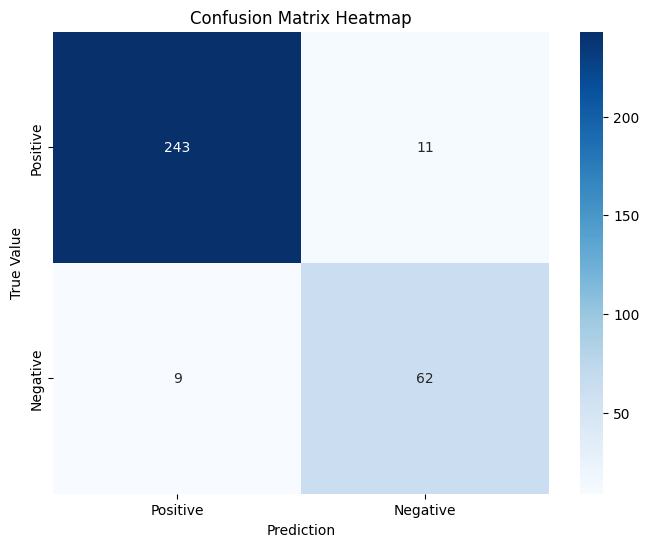

In [150]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Positive', 'Negative'], 
            yticklabels=['Positive', 'Negative'])
plt.xlabel('Prediction')
plt.ylabel('True Value')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [151]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid)

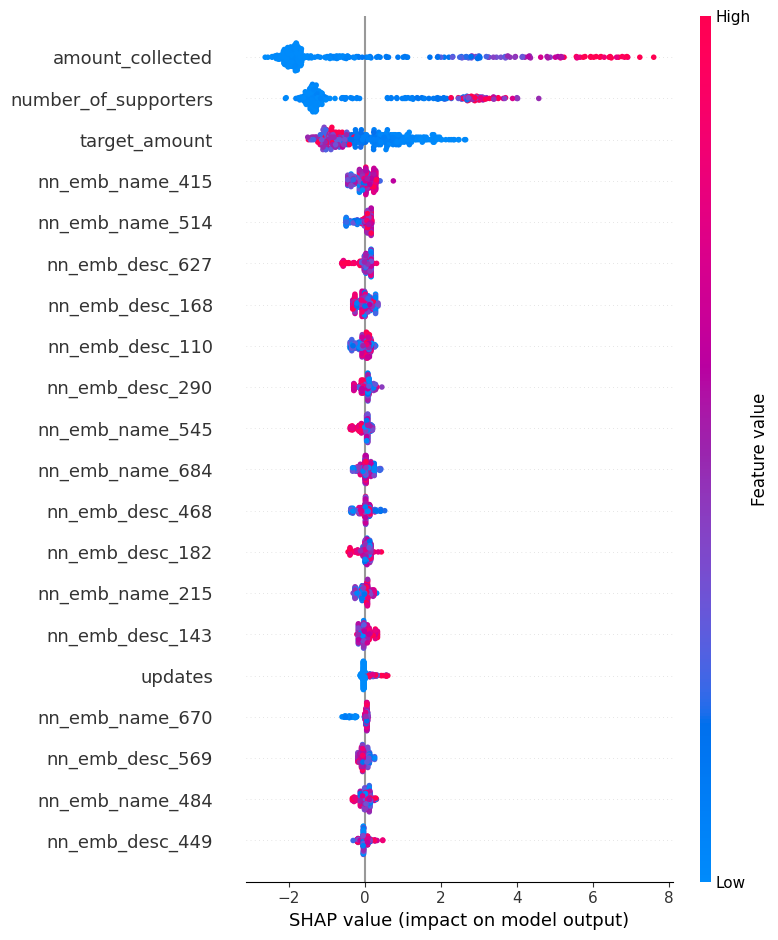

In [152]:
shap.summary_plot(shap_values, X_valid)